In [4]:
#%%
import os
import sys
import json
from argparse import ArgumentParser
import yaml
import torch
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from matplotlib import pyplot as plt
# personal files
os.chdir('/mnt/work/')
sys.path.append(os.path.join(os.path.dirname(__file__), '..', '..'))
import models
from datasets import MelDataset, vctkDataset

# path
os.chdir('/mnt/work/')

# config path
# data_config_path = "./Animal/configs/monkey/dataset2.yaml"
# dataset_config = yaml.load(open(data_config_path, "r"), Loader=yaml.FullLoader)
# analy_set = MelDataset(dataset_config, used_key = ['twin_1_0'], subset='test') # 
# analy_loader = DataLoader(analy_set, batch_size=1, shuffle=False)

#  dataset config loading
# data_config_path = "./Animal/configs/monkey/dataset4_lstm.yaml" 
data_config_path = "./Animal/configs/monkey/dataset2.yaml" 
dataset_config = yaml.load(open(data_config_path, "r"), Loader=yaml.FullLoader)

# used_key
# used_key = dataset_config["used_key"]
used_key = [[
              'calltype_1',
              'calltype_2',
              # 'calltype_3',
              # 'calltype_4',
              # 'calltype_5',
              # 'calltype_6',
              # 'calltype_7',
              # 'calltype_8',
              # 'calltype_9',
              # 'calltype_10'
                ],
                [
                'twin_1_0',
                'twin_1_1',
                'twin_2_2',
                'twin_2_3',
                'twin_3_4',
                'twin_3_5',
                'twin_4_6',
                'twin_4_7',
                # 'twin_5_8',
                # 'twin_5_9'
                  ]]

analy_set = MelDataset_lstm(dataset_config, used_key = used_key, subset='test')
analy_loader = DataLoader(analy_set, batch_size=1, shuffle=False)

# device
# torch.cuda.set_device(0)
torch.cuda.set_device(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model loading
# new f encoder lstm3
# old f encoder lstm
model_config_path = "./Animal/configs/monkey/model_lstm3.yaml" 
model_config = yaml.load(open(model_config_path, "r"), Loader=yaml.FullLoader)
model_name = model_config['model_name']
model_type = getattr(models, model_name) # model choose
# model = model_type(device = device, 
#                     module_config = {'static_encoder': model_config['static_encoder']}, 
#                     **model_config['DisentangledVAE1D']).to(device) # model config load
model = model_type(device = device, 
                   module_config = {'static_encoder': model_config['static_encoder']},
                   **model_config['DisentangledVAE1D']).to(device)


#load model
exp_name = 'DisentangledVAE1D-LSTM5'
model_path = 'Animal/output/monkey'
save_path = os.path.join(model_path, exp_name, 'checkpoint', "70000.pth.tar")
ckpt = torch.load(save_path)
model.load_state_dict(ckpt["model"])
model.eval()

# data store
total_f_mean = []
total_f_logvar = []
total_z_post_mean = []
total_z_post_logvar = []
total_z_prior_mean = []
total_z_prior_logvar = []

total_x_gt = [] # mel
total_x_rec = [] # reconstuct mel
total_ctID = []
total_cID = []

for mel, lenx, ctID, cID in tqdm(analy_loader):
        mel = mel.to(device)
        lenx = lenx.to(device)
        
        outputs = model(mel) 
        
        f_mean = outputs['f_mean'].detach().cpu().numpy()
        f_logvar = outputs['f_logvar'].detach().cpu().numpy()
        
        z_post_mean = outputs['z_post_mean'].detach().cpu().numpy() 
        z_post_logvar = outputs['z_post_logvar'].detach().cpu().numpy() 
        z_prior_mean = outputs['z_prior_mean'].detach().cpu().numpy() 
        z_prior_logvar = outputs['z_prior_logvar'].detach().cpu().numpy() 
        
        x_rec = outputs['recon_x'].detach().cpu().numpy()

        total_f_mean.append(f_mean)
        total_f_logvar.append(f_logvar)
        total_z_post_mean.append(z_post_mean)
        total_z_post_logvar.append(z_post_logvar)
        total_z_prior_mean.append(z_prior_mean)
        total_z_prior_logvar.append(z_prior_logvar)
        
        total_x_gt.append(mel.detach().cpu().numpy())
        total_x_rec.append(x_rec)
        total_ctID.append(ctID.detach().cpu().numpy())
        total_cID.append(cID.detach().cpu().numpy())

unique_elements, counts = np.unique(total_ctID, return_counts=True)
for element, count in zip(unique_elements, counts):
    print('ctID_counts',f"{element}: {count}")
    
unique_elements, counts = np.unique(total_cID, return_counts=True)
for element, count in zip(unique_elements, counts):
    print('cID_counts',f"{element}: {count}")
    


Dict_1 ['calltype_1', 'calltype_2']
Dict_2 ['twin_1_0', 'twin_1_1', 'twin_2_2', 'twin_2_3', 'twin_3_4', 'twin_3_5', 'twin_4_6', 'twin_4_7']


  0%|          | 0/7064 [00:00<?, ?it/s]

 10%|█         | 718/7064 [00:56<08:18, 12.73it/s]


KeyboardInterrupt: 

In [ ]:
print(total_f_mean[100].shape)

(1, 256)


In [ ]:
print(total_z_prior_mean[100].mean(1).shape)

(1, 32)


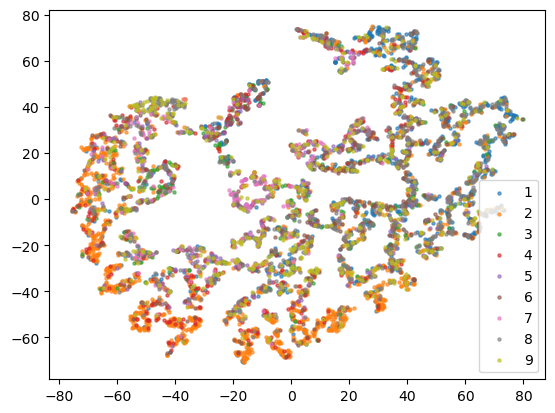

In [ ]:
from sklearn.manifold import TSNE

# call type
total_z_con_1D = []
for i in total_z_post_mean: # content: total_z_post_mean total_z_post_logvar
    total_z_con_1D.append(i.sum(1))

# tsne
total_z_con_1D = np.array(total_z_con_1D).squeeze()
tsne = TSNE(n_components = 2, perplexity = 30, n_iter = 1000)

data_2d = tsne.fit_transform(total_z_con_1D) # content

# Get unique labels
used_label = total_cID
unique_labels = np.unique(used_label)

# Plot the transformed data with labels
for label in unique_labels:
    # Select data for this label
    data_for_label = data_2d[np.all(used_label == label, axis=1)]
    
    # Plot the data for this label with a label for the legend
    plt.scatter(data_for_label[:, 0], data_for_label[:, 1], label=label, alpha=0.6, s=5)

# Add a legend
plt.legend()
plt.show()

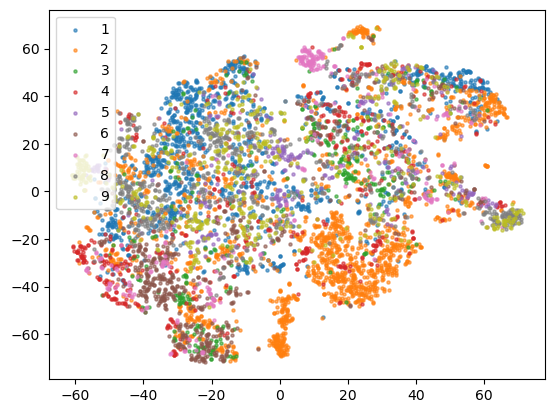

In [ ]:
from sklearn.manifold import TSNE

# total_z_con = 
# caller
total_z_indi = np.array(total_f_mean).squeeze() # indi total_f_mean total_f_logvar

# tsne
tsne = TSNE(n_components=2, perplexity = 30, n_iter = 1000)
data_2d = tsne.fit_transform(total_z_indi)

# Get unique labels
used_label = total_cID

unique_labels = np.unique(used_label)

# Plot the transformed data with labels
for label in unique_labels:
    # Select data for this label
    data_for_label = data_2d[np.all(used_label == label, axis=1)]
    
    # Plot the data for this label with a label for the legend
    plt.scatter(data_for_label[:, 0], data_for_label[:, 1], label=label, alpha=0.6, s=5)

# Add a legend
plt.legend()
plt.show()

In [ ]:
total_z_indi.shape
total_z_con_1D.shape

(6163, 32)